In [1]:
# GPU설정
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

# 3-1. 프로젝트: ResNet Ablation Study

## 0) 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 둘러봅시다.

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
# # TensorFlow and tf.keras
# import tensorflow as tf
# from tensorflow import keras

# # Helper libraries
# import numpy as np
# import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds
# from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings("ignore")

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import os

In [6]:
# !pip install -U tensorflow-datasets

     |████████████████████████████████| 5.0 MB 5.1 MB/s            
     |████████████████████████████████| 3.0 MB 60.8 MB/s            
     |████████████████████████████████| 294 kB 101.1 MB/s            
     |████████████████████████████████| 140 kB 77.2 MB/s            
     |████████████████████████████████| 153 kB 77.4 MB/s            
     |████████████████████████████████| 1.0 MB 70.3 MB/s            
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.4.0
    Uninstalling tensorflow-datasets-4.4.0:
      Successfully uninstalled tensorflow-datasets-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2,

In [9]:
# cats_vs_dogs 데이터셋 로드
# dataset_name = "cats_vs_dogs"
# (ds_train, ds_test), ds_info = tfds.load(
#     name=dataset_name,
#     split=["train[:80%]", "train[80%:]"],
#     as_supervised=True,
#     with_info=True
# )

# import urllib3#, clipnorm=1.),
# urllib3.disable_warnings()
# dataset_name = "cats_vs_dogs"
# #tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

# (ds_train, ds_valid, ds_test), ds_info = tfds.load(
#     'cats_vs_dogs',
#     split=[
#         'train[:80%]',
#         'train[80%:90%]',
#         'train[90%:]'
#     ],
#     as_supervised=True,
#     shuffle_files=True,
#     with_info=True,
# )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

DownloadError: Failed to get url https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip. HTTP code: 404.

In [12]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# import tensorflow_datasets as tfds

# setattr(tfds.image_classification.cats_vs_dogs, 
#         '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# (train_dataset, test_dataset), info = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:]'],
#     with_info=True,
#     as_supervised=True
# )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [47]:
print(info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [48]:
# 데이터 전처리 함수 정의
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 조정
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    return image, label

In [49]:
# 훈련 데이터셋의 전체 크기 계산
DATASET_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()

In [50]:
# 훈련 세트와 검증 세트의 분할 비율 설정
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VALIDATION_SIZE = int(0.2 * DATASET_SIZE)

In [51]:
# 데이터셋 분할 및 전처리 적용
BATCH_SIZE = 32  # 배치 크기 설정
ds_train = train_dataset.take(TRAIN_SIZE).map(preprocess).shuffle(1000).batch(BATCH_SIZE)
ds_validation = train_dataset.skip(TRAIN_SIZE).take(VALIDATION_SIZE).map(preprocess).batch(BATCH_SIZE)
ds_test = test_dataset.map(preprocess).batch(BATCH_SIZE)

In [52]:
# 데이터셋 크기 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_validation))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(466, shape=(), dtype=int64)
tf.Tensor(117, shape=(), dtype=int64)
tf.Tensor(146, shape=(), dtype=int64)


## 1) ResNet 기본 블록 구성하기
---
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

[Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

[빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

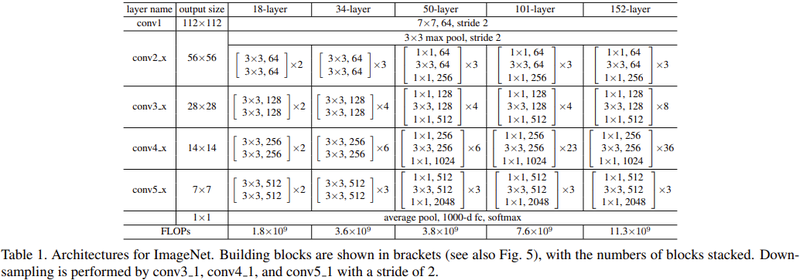

**Q. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.**

A.

- ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

ResNet(Residual Network)은 깊은 신경망을 효과적으로 학습할 수 있도록 설계된 구조로, "Deep Residual Learning for Image Recognition" 논문에서 소개되었습니다. 이 논문에서는 다양한 깊이의 ResNet 아키텍처가 제시되었는데, 그 중 ResNet-34와 ResNet-50이 대표적인 예입니다.

ResNet-34와 ResNet-50의 블록 구성에서의 공통점과 차이점을 비교해보겠습니다:

### 공통점
1. **잔차 연결(Residual Connection)**: 두 아키텍처 모두 잔차 연결을 사용합니다. 이는 입력을 네트워크의 출력에 더함으로써, 네트워크가 학습해야 할 함수의 복잡성을 줄여줍니다. 이는 깊은 네트워크에서 발생할 수 있는 소실된 기울기(vanishing gradient) 문제를 완화시키는 데 도움을 줍니다.

2. **레이어의 순차적 구성**: 두 모델 모두 레이어를 순차적으로 구성하며, 각 레이어는 이전 레이어의 출력을 입력으로 받습니다.

3. **기본 아키텍처**: 두 모델 모두 초기 층에서는 일반적인 합성곱, 배치 정규화, ReLU 활성화 함수, 최대 풀링을 사용합니다.

### 차이점
1. **블록의 종류 및 구성**: ResNet-34는 기본 블록(basic block)을 사용하는 반면, ResNet-50은 병목 블록(bottleneck block)을 사용합니다. 기본 블록은 두 개의 3x3 합성곱으로 구성되어 있으며, 병목 블록은 1x1, 3x3, 그리고 1x1 합성곱을 순서대로 사용합니다. 여기서 1x1 합성곱은 차원을 축소하거나 확장하는 데 사용됩니다.

2. **레이어의 깊이**: ResNet-34는 총 34개의 레이어로 구성되어 있으며, ResNet-50은 총 50개의 레이어로 구성됩니다. 이는 ResNet-50이 더 깊은 구조를 가지고 있다는 것을 의미합니다.

3. **파라미터의 수**: 병목 블록 구조를 사용하는 ResNet-50은 ResNet-34에 비해 더 많은 파라미터를 가집니다. 이는 ResNet-50이 더 복잡한 패턴을 학습할 수 있게 해주지만, 계산 비용과 메모리 사용량도 증가시킵니다.

4. **성능**: 일반적으로, ResNet-50은 ResNet-34보다 더 나은 성능을 제공합니다. 이는 더 깊은 네트워크와 복잡한 블록 구조가 더 정교한 특징을 학습할 수 있기 때문입니다.

### 결론
ResNet-34와 ResNet-50은 둘 다 잔차 연결을 사용하는 깊은 신경망으로, 입력과 출력 사이의 직접적인 연결을 통해 깊은 네트워크의 학습 문제를 완화합니다. 그러나 두 모델은 사용된 블록의 종류, 깊이, 파라미터 수에서 차이가 있으며, 이러한 차이는 모델의 성능과 계산 비용

에 영향을 미칩니다. ResNet-50은 더 깊고 복잡한 모델이며, 일반적으로 더 나은 성능을 제공하지만, 더 많은 계산 자원을 요구합니다.

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

## 2) ResNet-34, ResNet-50 Complete Model
---

    ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

### ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

"VGG"는 옥스퍼드 대학교의 Visual Geometry Group에서 개발한 컨볼루션 신경망(Convolutional Neural Network, CNN) 구조를 말합니다. 이 모델은 주로 이미지 인식과 분류 작업에 사용됩니다. VGG는 특히 그 구조의 단순함과 깊이가 높은 특징으로 유명합니다.

### VGG의 주요 특징
1. **일관된 컨볼루션 레이어**: VGG는 모든 컨볼루션 레이어에서 3x3 필터를 사용합니다. 이는 네트워크의 깊이를 늘리면서도 파라미터 수를 효율적으로 유지하는 방법입니다.

2. **깊은 네트워크 구조**: VGG는 여러 개의 컨볼루션 레이어를 연속적으로 쌓아 네트워크를 깊게 만듭니다. VGG-16은 16개의 레이어를 가지고 있으며, VGG-19는 19개의 레이어를 가집니다.

3. **풀링 레이어**: 컨볼루션 레이어 사이에는 풀링 레이어(Max Pooling)가 배치되어 특징 맵(feature map)의 크기를 줄입니다.

4. **완전 연결 레이어**: 네트워크의 마지막 부분에는 이미지 분류를 위한 몇 개의 완전 연결 레이어(Fully Connected Layers)가 있습니다.

### VGG의 사용
VGG는 ImageNet Large Scale Visual Recognition Challenge(ILSVRC)에서 좋은 성능을 보여주었으며, 많은 컴퓨터 비전 관련 연구 및 프로젝트에서 기준점(baseline)으로 사용됩니다. 그 구조의 단순함과 효과성 덕분에 널리 사용되며, 많은 변형과 실험의 기초가 되고 있습니다.

VGG 모델은 컴퓨터 비전 분야에서 깊은 학습 모델의 발전에 큰 영향을 미쳤으며, 많은 후속 연구와 아키텍처 개발에 영감을 주었습니다.

물론이죠, 설명드리겠습니다. 여기서 언급된 "VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 보자"는 것은 딥러닝에서 모델을 구성하는 하나의 방법을 말합니다. 이 방법은 여러 레이어(layer)를 반복적으로 사용하여 하나의 큰 모델을 구성하는 데 사용됩니다.

### ResNet-34와 ResNet-50의 차이점

ResNet-34와 ResNet-50은 둘 다 ResNet 계열의 모델이지만, 레이어의 구성과 깊이가 다릅니다.

- **ResNet-34**는 각 블록이 3x3 컨볼루션 레이어 2개로 구성되어 있습니다.
- **ResNet-50**은 병목(bottleneck) 구조를 사용하여, 각 블록이 1x1, 3x3, 그리고 1x1 컨볼루션 레이어 3개로 구성되어 있습니다.

### 블록 기반 모델 구축

블록 기반 모델 구축은 다음과 같은 단계로 이루어집니다:

1. **블록 정의**: 먼저 모델의 기본이 되는 블록을 정의합니다. ResNet의 경우, 이 블록은 컨볼루션 레이어와 배치 정규화(batch normalization), 활성화 함수(예: ReLU)로 구성됩니다.

2. **블록을 사용하여 모델 구성**: 이 블록을 여러 번 반복하여 모델을 구성합니다. 예를 들어, ResNet-34와 ResNet-50은 서로 다른 수와 종류의 블록을 사용합니다.

3. **입력과 출력 정의**: 모델의 입력(input)과 출력(output)을 정의합니다. 일반적으로 입력은 이미지 데이터, 출력은 분류(classification)을 위한 레이어(예: softmax 레이어)입니다.

4. **전체 모델 생성**: 정의된 블록들과 입력, 출력 레이어를 연결하여 전체 모델을 만듭니다.

### 함수로 모델 생성

`build_resnet()` 같은 함수를 사용하여 다양한 버전의 ResNet 모델을 생성할 수 있습니다. 이 함수는 모델의 구성을 파라미터로 받아서, 해당 파라미터에 따라 ResNet-34 또는 ResNet-50을 생성합니다. 예를 들어, ResNet-34를 만들려면 블록의 수와 유형을 ResNet-34에 맞게 설정하고, ResNet-50을 만들려면 ResNet-50에 맞게 설정합니다.

이런 방식으로 하나의 함수로 여러 버전의 모델을 생성할 수 있으며, 코드 재사용성과 유연성이 높아집니다.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils

def conv_bn_relu(x, filters, kernel_size, strides=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

In [18]:
def residual_block(input_tensor, filters, strides=1, use_conv_shortcut=True):
    x = conv_bn_relu(input_tensor, filters, 3, strides)
    x = conv_bn_relu(x, filters, 3, activation=None)

    if use_conv_shortcut or strides != 1:
        shortcut = conv_bn_relu(input_tensor, filters, 1, strides, activation=None)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [19]:
def build_resnet34(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = conv_bn_relu(inputs, 64, 7, 2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 2
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Stage 3
    x = residual_block(x, 128, 2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Stage 4
    x = residual_block(x, 256, 2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    # Stage 5
    x = residual_block(x, 512, 2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, x)

In [20]:
def bottleneck_block(input_tensor, filters, strides=1, use_conv_shortcut=False):
    filters1, filters2, filters3 = filters

    x = conv_bn_relu(input_tensor, filters1, (1, 1), strides)
    x = conv_bn_relu(x, filters2, (3, 3))
    x = layers.Conv2D(filters3, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    shortcut = input_tensor
    if use_conv_shortcut or strides != 1:
        shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, padding='same', use_bias=False)(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [21]:
def build_resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = conv_bn_relu(inputs, 64, (7, 7), 2)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Stage 2
    x = bottleneck_block(x, [64, 64, 256], strides=1, use_conv_shortcut=True)
    x = bottleneck_block(x, [64, 64, 256])
    x = bottleneck_block(x, [64, 64, 256])

    # Stage 3
    x = bottleneck_block(x, [128, 128, 512], strides=2, use_conv_shortcut=True)
    for _ in range(3):
        x = bottleneck_block(x, [128, 128, 512])

    # Stage 4
    x = bottleneck_block(x, [256, 256, 1024], strides=2, use_conv_shortcut=True)
    for _ in range(5):
        x = bottleneck_block(x, [256, 256, 1024])

    # Stage 5
    x = bottleneck_block(x, [512, 512, 2048], strides=2, use_conv_shortcut=True)
    x = bottleneck_block(x, [512, 512, 2048])
    x = bottleneck_block(x, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x, name='resnet50')
    return model

In [22]:
def build_resnet(input_shape=(32, 32, 3), is_50=False, num_classes=10):
    if is_50:
        return build_resnet50(input_shape, num_classes)
    else:
        return build_resnet34(input_shape, num_classes)

In [23]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

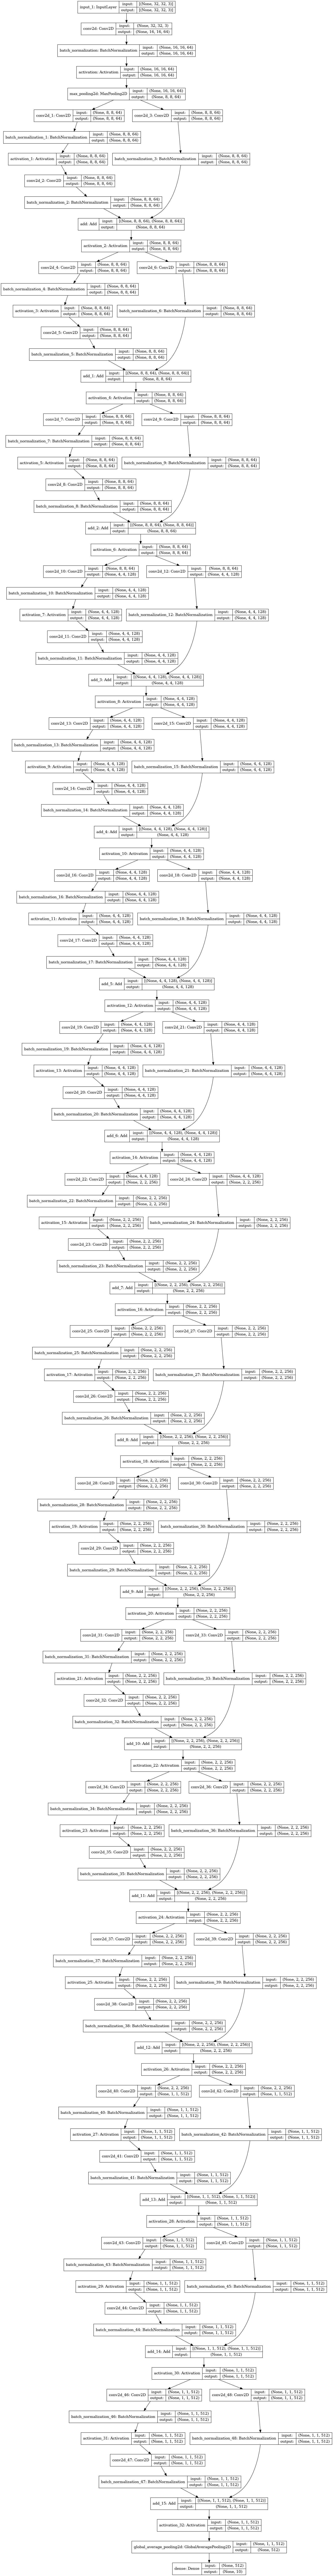

In [24]:
utils.plot_model(resnet_34, show_shapes = True)

ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [25]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 16, 16, 64)   9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 16, 16, 64)   256         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_49[0][0]     
___________________________________________________________________________________________

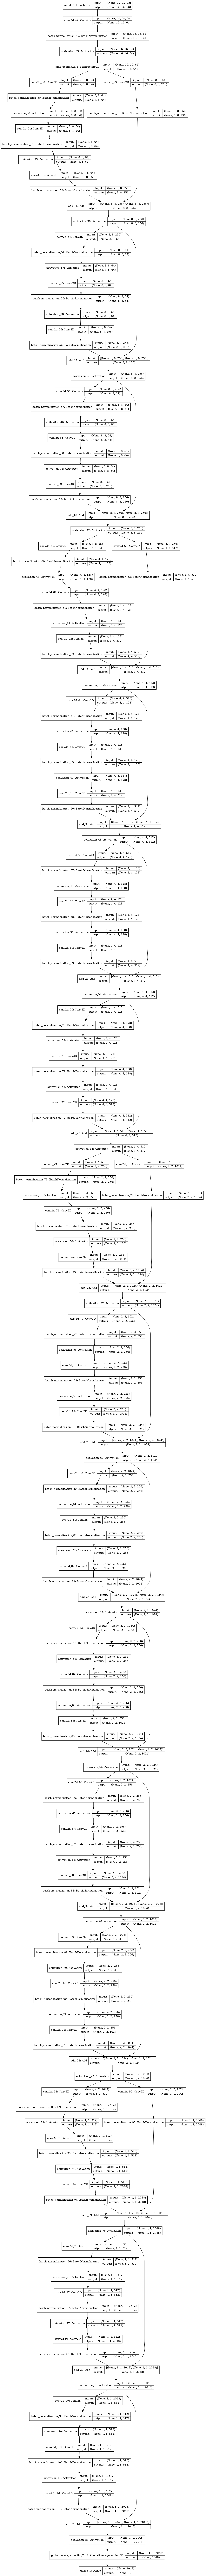

In [26]:
utils.plot_model(resnet_50, show_shapes = True)

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

- [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

3) 일반 네트워크(plain network) 만들기
블록 코드 수정하기
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

이 프로젝트는 ResNet과 이와 유사한 구조이지만 skip connection이 없는 일반 네트워크(Plain Network)를 구현하고, 그 차이를 비교하는 것입니다. 먼저 ResNet 블록을 만들기 위한 함수를 수정하여 skip connection이 없는 블록을 만들 수 있도록 합시다.

다음으로, ResNet-34, ResNet-50 및 PlainNet-34, PlainNet-50을 만들 수 있는 함수 `build_plainnet`를 구현하겠습니다. 이 함수는 입력 이미지 크기가 (224, 224, 3)이어야 합니다.

In [27]:
# 1. ResNet 및 PlainNet 블록 함수 수정
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_bn_relu(x, filters, kernel_size, strides=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def residual_block(input_tensor, filters, strides=1, use_conv_shortcut=True, use_skip_connection=True):
    x = conv_bn_relu(input_tensor, filters, 3, strides)
    x = conv_bn_relu(x, filters, 3, activation=None)

    if use_skip_connection:
        if use_conv_shortcut or strides != 1:
            shortcut = conv_bn_relu(input_tensor, filters, 1, strides, activation=None)
        else:
            shortcut = input_tensor

        x = layers.Add()([x, shortcut])
    
    x = layers.Activation('relu')(x)
    return x

In [28]:
# 2. 전체 함수 코드 수정 (ResNet 및 PlainNet)
def build_resnet(input_shape=(224, 224, 3), num_classes=10, is_50=False, use_skip_connection=True):
    inputs = layers.Input(shape=input_shape)
    x = conv_bn_relu(inputs, 64, 7, 2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    if is_50:  # ResNet-50 or PlainNet-50
        filter_list = [64, 128, 256, 512]
        block_list = [3, 4, 6, 3]
    else:  # ResNet-34 or PlainNet-34
        filter_list = [64, 128, 256, 512]
        block_list = [3, 4, 6, 3]

    for filters, blocks in zip(filter_list, block_list):
        for i in range(blocks):
            if i == 0 and filters != 64:
                x = residual_block(x, filters, strides=2, use_conv_shortcut=True, use_skip_connection=use_skip_connection)
            else:
                x = residual_block(x, filters, use_skip_connection=use_skip_connection)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x, name='resnet' if use_skip_connection else 'plainnet')
    return model

# ResNet 및 PlainNet 모델 예시
resnet_34 = build_resnet(is_50=False)
resnet_50 = build_resnet(is_50=True)
plainnet_34 = build_resnet(is_50=False, use_skip_connection=False)
plainnet_50 = build_resnet(is_50=True, use_skip_connection=False)

# 모델 구조 확인
resnet_34.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 112, 112, 64) 9408        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 112, 112, 64) 256         conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_102[0][0]    
_____________________________________________________________________________________________

In [29]:
resnet_50.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_151 (BatchN (None, 112, 112, 64) 256         conv2d_151[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 112, 112, 64) 0           batch_normalization_151[0][0]    
_____________________________________________________________________________________________

In [30]:
plainnet_34.summary()

Model: "plainnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_200 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_148 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 56, 56, 64)        36864     
_________________________________________________________________
batch_normalization_201 (Bat (None, 56, 56, 64)        256

In [31]:
plainnet_50.summary()

Model: "plainnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_233 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_181 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 56, 56, 64)        36864     
_________________________________________________________________
batch_normalization_234 (Bat (None, 56, 56, 64)        256

위 코드는 ResNet 및 PlainNet의 블록을 만드는 함수를 수정하고, 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합니다. ResNet 모델과 PlainNet 모델 사이의 주요 차이점은 skip connection의 유무입니다. 위 코드를 통해 두 아키텍처의 차이를 명확히 비교하고 분석할 수 있습니다.

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
Ablation Study
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

### ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34 Ablation Study

Ablation Study는 모델이나 기술의 특정 부분이 전체 성능에 미치는 영향을 평가하기 위해 수행됩니다. 이 경우, ResNet과 Plain Network의 성능 차이를 평가하여 ResNet의 잔차 연결(residual connections)이 모델 성능에 어떤 영향을 미치는지 평가합니다.

#### 실험 방법
1. **데이터셋 선택**: 실험에 사용할 데이터셋으로는 cats_vs_dogs를 추천합니다. 이 데이터셋은 tensorflow-datasets에서 제공되며, 224x224 픽셀 크기의 이미지로 구성되어 있습니다. 


2. **모델 구성**: ResNet-50과 Plain-50, ResNet-34와 Plain-34 각각을 구현합니다. 위에서 제공된 함수를 사용하여 모델을 생성할 수 있습니다.


3. **학습 설정**: 각 모델을 동일한 조건에서 학습시켜 비교합니다. 학습 조건으로는 학습률, 배치 크기, 최적화 방법 등이 포함됩니다. 시간 제약으로 인해 적은 epoch로 설정하고, 오버피팅을 방지하기 위해 조기 종료(Early Stopping) 또는 드롭아웃(Dropout)을 고려할 수 있습니다.


4. **성능 평가**: 학습된 모델의 성능을 평가하기 위해 검증 데이터셋을 사용합니다. 주로 사용되는 평가 지표는 정확도, 정밀도, 재현율 등입니다.



In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

In [33]:
def conv_bn_relu(x, filters, kernel_size, strides=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def residual_block(input_tensor, filters, strides=1, use_conv_shortcut=True, use_skip_connection=True):
    x = conv_bn_relu(input_tensor, filters, 3, strides)
    x = conv_bn_relu(x, filters, 3, activation=None)

    if use_skip_connection:
        if use_conv_shortcut or strides != 1:
            shortcut = conv_bn_relu(input_tensor, filters, 1, strides, activation=None)
        else:
            shortcut = input_tensor

        x = layers.Add()([x, shortcut])
    
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=False, use_skip_connection=True):
    inputs = layers.Input(shape=input_shape)
    x = conv_bn_relu(inputs, 64, 7, 2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    if is_50:  # ResNet-50 or PlainNet-50
        filter_list = [64, 128, 256, 512]
        block_list = [3, 4, 6, 3]
    else:  # ResNet-34 or PlainNet-34
        filter_list = [64, 128, 256, 512]
        block_list = [3, 4, 6, 3]

    for filters, blocks in zip(filter_list, block_list):
        for i in range(blocks):
            if i == 0 and filters != 64:
                x = residual_block(x, filters, strides=2, use_conv_shortcut=True, use_skip_connection=use_skip_connection)
            else:
                x = residual_block(x, filters, use_skip_connection=use_skip_connection)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x, name='resnet' if use_skip_connection else 'plainnet')
    return model

In [64]:
# 모델 생성
resnet_50 = build_resnet(is_50=True)
plain_50 = build_resnet(is_50=True, use_skip_connection=False)

In [65]:
# 모델 컴파일
resnet_50.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
plain_50.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [66]:
## ResNet-50 모델 체크포인트 저장 경로
checkpoint_path_resnet_50 = "training_resnet_50/cp.ckpt"
checkpoint_dir_resnet_50 = os.path.dirname(checkpoint_path_resnet_50)

# Plain-50 모델 체크포인트 저장 경로
checkpoint_path_plain_50 = "training_plain_50/cp.ckpt"
checkpoint_dir_plain_50 = os.path.dirname(checkpoint_path_plain_50)

# 모델 체크포인트 저장을 위한 콜백 생성
cp_callback_resnet_50 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_resnet_50,
                                                           save_weights_only=True,
                                                           verbose=1)

cp_callback_plain_50 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_plain_50,
                                                          save_weights_only=True,
                                                          verbose=1)


In [67]:
# 모델 학습 renet_50
history_resnet_50 = resnet_50.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation,
    callbacks=[cp_callback_resnet_50]  # 콜백 추가
)

Epoch 1/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.7357 - accuracy: 0.5968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.7264 - accuracy: 0.5914

209/466 [============>.................] - ETA: 53s - loss: 0.7251 - accuracy: 0.5911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.7089 - accuracy: 0.5965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.6089

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 113s 233ms/step - loss: 0.6854 - accuracy: 0.6089 - val_loss: 1.0071 - val_accuracy: 0.5164

Epoch 00001: saving model to training_resnet_50/cp.ckpt
Epoch 2/10
166/466 [=========>....................] - ETA: 1:01 - loss: 0.6355 - accuracy: 0.6547

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 54s - loss: 0.6337 - accuracy: 0.6552

209/466 [============>.................] - ETA: 52s - loss: 0.6312 - accuracy: 0.6577

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.6306 - accuracy: 0.6556

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6685

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.6156 - accuracy: 0.6685 - val_loss: 0.8300 - val_accuracy: 0.5701

Epoch 00002: saving model to training_resnet_50/cp.ckpt
Epoch 3/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.5711 - accuracy: 0.7101

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.5652 - accuracy: 0.7126

209/466 [============>.................] - ETA: 53s - loss: 0.5655 - accuracy: 0.7126

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.5600 - accuracy: 0.7152

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.7266

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.5445 - accuracy: 0.7266 - val_loss: 0.7491 - val_accuracy: 0.6013

Epoch 00003: saving model to training_resnet_50/cp.ckpt
Epoch 4/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.4946 - accuracy: 0.7575

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.4924 - accuracy: 0.7604

209/466 [============>.................] - ETA: 53s - loss: 0.4937 - accuracy: 0.7606

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.4891 - accuracy: 0.7636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.7738

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.4721 - accuracy: 0.7738 - val_loss: 0.6491 - val_accuracy: 0.6916

Epoch 00004: saving model to training_resnet_50/cp.ckpt
Epoch 5/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.4195 - accuracy: 0.8085

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.4132 - accuracy: 0.8116

209/466 [============>.................] - ETA: 53s - loss: 0.4118 - accuracy: 0.8122

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.4058 - accuracy: 0.8157

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8214

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 110s 233ms/step - loss: 0.3940 - accuracy: 0.8214 - val_loss: 0.9737 - val_accuracy: 0.5626

Epoch 00005: saving model to training_resnet_50/cp.ckpt
Epoch 6/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.3454 - accuracy: 0.8518

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.3434 - accuracy: 0.8508

209/466 [============>.................] - ETA: 53s - loss: 0.3418 - accuracy: 0.8518

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.3440 - accuracy: 0.8504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8568

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.3319 - accuracy: 0.8568 - val_loss: 3.6692 - val_accuracy: 0.5605

Epoch 00006: saving model to training_resnet_50/cp.ckpt
Epoch 7/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.2938 - accuracy: 0.8716

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.2935 - accuracy: 0.8725

209/466 [============>.................] - ETA: 53s - loss: 0.2967 - accuracy: 0.8714

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.2907 - accuracy: 0.8738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 233ms/step - loss: 0.2826 - accuracy: 0.8780 - val_loss: 1.4514 - val_accuracy: 0.5137

Epoch 00007: saving model to training_resnet_50/cp.ckpt
Epoch 8/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.2737 - accuracy: 0.8810

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.2673 - accuracy: 0.8838

209/466 [============>.................] - ETA: 53s - loss: 0.2676 - accuracy: 0.8838

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.2647 - accuracy: 0.8859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8910

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.2576 - accuracy: 0.8910 - val_loss: 0.7385 - val_accuracy: 0.7550

Epoch 00008: saving model to training_resnet_50/cp.ckpt
Epoch 9/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.2501 - accuracy: 0.8963

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.2410 - accuracy: 0.8989

209/466 [============>.................] - ETA: 53s - loss: 0.2390 - accuracy: 0.8994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/466 [=================>............] - ETA: 38s - loss: 0.2353 - accuracy: 0.9002

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9057

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.2287 - accuracy: 0.9057 - val_loss: 0.3882 - val_accuracy: 0.8525

Epoch 00009: saving model to training_resnet_50/cp.ckpt
Epoch 10/10
166/466 [=========>....................] - ETA: 1:02 - loss: 0.2092 - accuracy: 0.9136

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.2049 - accuracy: 0.9160

209/466 [============>.................] - ETA: 53s - loss: 0.2047 - accuracy: 0.9160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.2010 - accuracy: 0.9174

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9194

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 110s 232ms/step - loss: 0.1951 - accuracy: 0.9194 - val_loss: 0.4725 - val_accuracy: 0.7821

Epoch 00010: saving model to training_resnet_50/cp.ckpt


In [68]:
# 모델 학습 plain_50
history_plain_50 = plain_50.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation,
    callbacks=[cp_callback_plain_50]
)

Epoch 1/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6956 - accuracy: 0.5339

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6949 - accuracy: 0.5323

209/466 [============>.................] - ETA: 45s - loss: 0.6945 - accuracy: 0.5298

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6977 - accuracy: 0.5224

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5147

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 97s 202ms/step - loss: 0.6962 - accuracy: 0.5147 - val_loss: 0.6935 - val_accuracy: 0.5382

Epoch 00001: saving model to training_plain_50/cp.ckpt
Epoch 2/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6969 - accuracy: 0.5297

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6963 - accuracy: 0.5259

209/466 [============>.................] - ETA: 45s - loss: 0.6963 - accuracy: 0.5292

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6964 - accuracy: 0.5315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5270

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 202ms/step - loss: 0.6944 - accuracy: 0.5270 - val_loss: 2.4206 - val_accuracy: 0.5510

Epoch 00002: saving model to training_plain_50/cp.ckpt
Epoch 3/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6937 - accuracy: 0.5273

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6933 - accuracy: 0.5286

209/466 [============>.................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5284

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6910 - accuracy: 0.5360

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5322

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6902 - accuracy: 0.5322 - val_loss: 2.8873 - val_accuracy: 0.5019

Epoch 00003: saving model to training_plain_50/cp.ckpt
Epoch 4/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6898 - accuracy: 0.5375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6898 - accuracy: 0.5366

209/466 [============>.................] - ETA: 45s - loss: 0.6897 - accuracy: 0.5399

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6879 - accuracy: 0.5440

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5394

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6872 - accuracy: 0.5394 - val_loss: 0.9563 - val_accuracy: 0.5051

Epoch 00004: saving model to training_plain_50/cp.ckpt
Epoch 5/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6900 - accuracy: 0.5337

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6890 - accuracy: 0.5375

209/466 [============>.................] - ETA: 45s - loss: 0.6889 - accuracy: 0.5363

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6877 - accuracy: 0.5407

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5399

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6875 - accuracy: 0.5399 - val_loss: 0.6847 - val_accuracy: 0.5422

Epoch 00005: saving model to training_plain_50/cp.ckpt
Epoch 6/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6882 - accuracy: 0.5380

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6900 - accuracy: 0.5312

209/466 [============>.................] - ETA: 45s - loss: 0.6899 - accuracy: 0.5327

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6898 - accuracy: 0.5345

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5409

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6882 - accuracy: 0.5409 - val_loss: 0.6885 - val_accuracy: 0.5500

Epoch 00006: saving model to training_plain_50/cp.ckpt
Epoch 7/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6865 - accuracy: 0.5356

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6878 - accuracy: 0.5345

209/466 [============>.................] - ETA: 45s - loss: 0.6876 - accuracy: 0.5324

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6867 - accuracy: 0.5365

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5363

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6857 - accuracy: 0.5363 - val_loss: 0.7075 - val_accuracy: 0.5540

Epoch 00007: saving model to training_plain_50/cp.ckpt
Epoch 8/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6877 - accuracy: 0.5484

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6890 - accuracy: 0.5446

209/466 [============>.................] - ETA: 45s - loss: 0.6882 - accuracy: 0.5444

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6871 - accuracy: 0.5462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5379

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6872 - accuracy: 0.5379 - val_loss: 0.6838 - val_accuracy: 0.5605

Epoch 00008: saving model to training_plain_50/cp.ckpt
Epoch 9/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6879 - accuracy: 0.5488

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6884 - accuracy: 0.5444

209/466 [============>.................] - ETA: 45s - loss: 0.6874 - accuracy: 0.5441

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6866 - accuracy: 0.5477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5429

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6872 - accuracy: 0.5429 - val_loss: 0.6866 - val_accuracy: 0.4965

Epoch 00009: saving model to training_plain_50/cp.ckpt
Epoch 10/10
166/466 [=========>....................] - ETA: 53s - loss: 0.6884 - accuracy: 0.5352

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6888 - accuracy: 0.5352

209/466 [============>.................] - ETA: 45s - loss: 0.6884 - accuracy: 0.5366

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6881 - accuracy: 0.5413

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5428

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 94s 200ms/step - loss: 0.6865 - accuracy: 0.5428 - val_loss: 0.6949 - val_accuracy: 0.4965

Epoch 00010: saving model to training_plain_50/cp.ckpt


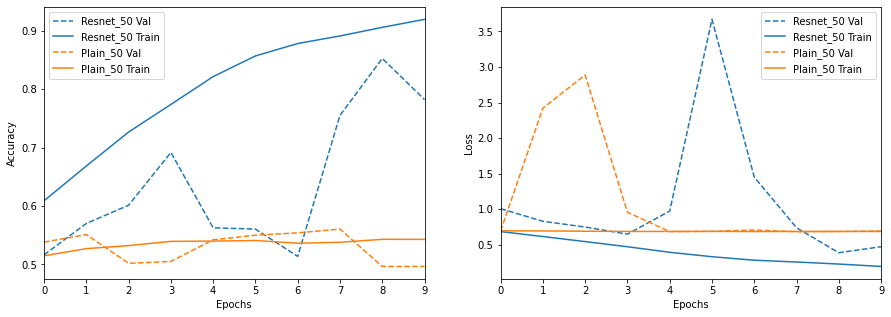

In [69]:
import matplotlib.pyplot as plt

def plot_history(histories, keys=('accuracy', 'loss')):
    plt.figure(figsize=(15, 5))

    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx + 1)

        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_' + key],
                           '--', label=name.title() + ' Val')
            plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                     label=name.title() + ' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_', ' ').title())
        plt.legend()
        plt.xlim([0, max(history.epoch)])

plot_history([('resnet_50', history_resnet_50),
              ('plain_50', history_plain_50)])


In [73]:
# 학습 기록(history) 저장
import pickle

# ResNet-50 history 저장
with open('history_resnet_50.pkl', 'wb') as file_pi:
    pickle.dump(history_resnet_50, file_pi)

# Plain-50 history 저장
with open('history_plain_50.pkl', 'wb') as file_pi:
    pickle.dump(history_plain_50, file_pi)

## 저장된 모델 불러보기

In [74]:
# 저장된 모델 가중치 불러오기
resnet_50.load_weights(checkpoint_path_resnet_50)
plain_50.load_weights(checkpoint_path_plain_50)

In [75]:
# 저장된 학습 기록 불러오기
with open('history_resnet_50.pkl', 'rb') as file_pi:
    history_resnet_50 = pickle.load(file_pi)

with open('history_plain_50.pkl', 'rb') as file_pi:
    history_plain_50 = pickle.load(file_pi)

In [76]:
# 추가 학습 진행
additional_epochs = 5

additional_history_resnet_50 = resnet_50.fit(
    ds_train,
    epochs=additional_epochs,
    validation_data=ds_validation,
    callbacks=[cp_callback_resnet_50]
)

Epoch 1/5
166/466 [=========>....................] - ETA: 1:02 - loss: 0.1918 - accuracy: 0.9207

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.1850 - accuracy: 0.9226

209/466 [============>.................] - ETA: 53s - loss: 0.1840 - accuracy: 0.9233

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.1779 - accuracy: 0.9256

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9270

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 233ms/step - loss: 0.1792 - accuracy: 0.9270 - val_loss: 0.4900 - val_accuracy: 0.8482

Epoch 00001: saving model to training_resnet_50/cp.ckpt
Epoch 2/5
166/466 [=========>....................] - ETA: 1:02 - loss: 0.1761 - accuracy: 0.9300

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.1742 - accuracy: 0.9303

209/466 [============>.................] - ETA: 53s - loss: 0.1731 - accuracy: 0.9303

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.1735 - accuracy: 0.9292

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9292

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.1732 - accuracy: 0.9292 - val_loss: 0.3853 - val_accuracy: 0.8654

Epoch 00002: saving model to training_resnet_50/cp.ckpt
Epoch 3/5
166/466 [=========>....................] - ETA: 1:02 - loss: 0.1436 - accuracy: 0.9381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 55s - loss: 0.1438 - accuracy: 0.9386

209/466 [============>.................] - ETA: 53s - loss: 0.1430 - accuracy: 0.9394

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.1443 - accuracy: 0.9396

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9414

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 117s 249ms/step - loss: 0.1436 - accuracy: 0.9414 - val_loss: 0.5549 - val_accuracy: 0.8251

Epoch 00003: saving model to training_resnet_50/cp.ckpt
Epoch 4/5
166/466 [=========>....................] - ETA: 1:02 - loss: 0.1318 - accuracy: 0.9473

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/466 [===========>..................] - ETA: 55s - loss: 0.1308 - accuracy: 0.9474

209/466 [============>.................] - ETA: 53s - loss: 0.1296 - accuracy: 0.9478

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.1259 - accuracy: 0.9492

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9451

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 109s 232ms/step - loss: 0.1337 - accuracy: 0.9451 - val_loss: 0.3933 - val_accuracy: 0.8426

Epoch 00004: saving model to training_resnet_50/cp.ckpt
Epoch 5/5
166/466 [=========>....................] - ETA: 1:03 - loss: 0.1309 - accuracy: 0.9494

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 56s - loss: 0.1269 - accuracy: 0.9512

209/466 [============>.................] - ETA: 54s - loss: 0.1266 - accuracy: 0.9519

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 38s - loss: 0.1268 - accuracy: 0.9515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9508

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 111s 236ms/step - loss: 0.1253 - accuracy: 0.9508 - val_loss: 0.6203 - val_accuracy: 0.7399

Epoch 00005: saving model to training_resnet_50/cp.ckpt


In [77]:
additional_history_plain_50 = plain_50.fit(
    ds_train,
    epochs=additional_epochs,
    validation_data=ds_validation,
    callbacks=[cp_callback_plain_50]
)

Epoch 1/5
166/466 [=========>....................] - ETA: 53s - loss: 0.6932 - accuracy: 0.4964

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6937 - accuracy: 0.4942

209/466 [============>.................] - ETA: 45s - loss: 0.6941 - accuracy: 0.4931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6945 - accuracy: 0.4958

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6935 - accuracy: 0.4989 - val_loss: 0.6968 - val_accuracy: 0.5570

Epoch 00001: saving model to training_plain_50/cp.ckpt
Epoch 2/5
166/466 [=========>....................] - ETA: 53s - loss: 0.6874 - accuracy: 0.5335

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6873 - accuracy: 0.5364

209/466 [============>.................] - ETA: 45s - loss: 0.6870 - accuracy: 0.5389

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6854 - accuracy: 0.5452

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5501

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 94s 200ms/step - loss: 0.6814 - accuracy: 0.5501 - val_loss: 0.6772 - val_accuracy: 0.5639

Epoch 00002: saving model to training_plain_50/cp.ckpt
Epoch 3/5
166/466 [=========>....................] - ETA: 53s - loss: 0.6889 - accuracy: 0.5290

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6887 - accuracy: 0.5294

209/466 [============>.................] - ETA: 45s - loss: 0.6887 - accuracy: 0.5280

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6863 - accuracy: 0.5408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5461

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6834 - accuracy: 0.5461 - val_loss: 0.7447 - val_accuracy: 0.5035

Epoch 00003: saving model to training_plain_50/cp.ckpt
Epoch 4/5
166/466 [=========>....................] - ETA: 53s - loss: 0.6815 - accuracy: 0.5550

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6802 - accuracy: 0.5573

209/466 [============>.................] - ETA: 45s - loss: 0.6806 - accuracy: 0.5573

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6795 - accuracy: 0.5617

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5603

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 94s 200ms/step - loss: 0.6804 - accuracy: 0.5603 - val_loss: 0.6930 - val_accuracy: 0.5325

Epoch 00004: saving model to training_plain_50/cp.ckpt
Epoch 5/5
166/466 [=========>....................] - ETA: 53s - loss: 0.6783 - accuracy: 0.5610

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/466 [===========>..................] - ETA: 47s - loss: 0.6789 - accuracy: 0.5601

209/466 [============>.................] - ETA: 45s - loss: 0.6783 - accuracy: 0.5606

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/466 [=================>............] - ETA: 32s - loss: 0.6767 - accuracy: 0.5652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/466 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5633

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/466 [==============================] - 95s 201ms/step - loss: 0.6760 - accuracy: 0.5633 - val_loss: 0.6985 - val_accuracy: 0.5637

Epoch 00005: saving model to training_plain_50/cp.ckpt


In [78]:
# 이전과 추가 학습 기록 결합
for key in additional_history_resnet_50.history:
    history_resnet_50[key].extend(additional_history_resnet_50.history[key])

for key in additional_history_plain_50.history:
    history_plain_50[key].extend(additional_history_plain_50.history[key])

AttributeError: 'dict' object has no attribute 'epoch'

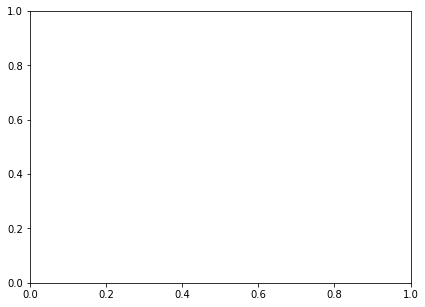

In [79]:
import matplotlib.pyplot as plt

def plot_history(histories, keys=('accuracy', 'loss')):
    plt.figure(figsize=(15, 5))

    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx + 1)

        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_' + key],
                           '--', label=name.title() + ' Val')
            plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                     label=name.title() + ' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_', ' ').title())
        plt.legend()
        plt.xlim([0, max(history.epoch)])

plot_history([('resnet_50', history_resnet_50),
              ('plain_50', history_plain_50)])

이 실험을 통해 잔차 연결의 유무가 모델의 학습 능력과 일반화 능력에 어떤 영향을 미치는지 관찰할 수 있습니다. ResNet이 Plain Network보다 더 나은 성능을 보여준다면, 이는 잔차 연결이 깊은 네트워크의 학습에 긍정적인 영향을 미치는 것으로 해석할 수 있습니다.

혹시 에러가 발생했나요? 그렇다면 다음의 링크를 읽어보세요

- [tensorflow_datasets.load('cats_vs_dogs') not working !](https://github.com/tensorflow/datasets/issues/3918)

**Q. 어떤 에러가 발생했을까요?**

발생한 에러가 Download error라면, Tensorflow에서 api내에 제공되어있는 링크를 교체한 후 업데이트를 하지 않아 발생한 문제입니다. 데이터를 로드하기 전에, 다음과 같이 변수를 조작하여 새 링크를 반영할 수 있습니다.

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

새 링크의 데이터셋 폴더 구조는 여러분들이 사용하셨던 CIFAR-10과는 다르게, 학습 세트가 구분되어 있지 않습니다. 학습을 잘 해내기 위해서는, 용도에 따라 데이터셋을 나누어야 하겠군요!

API 에러이지만 겁먹지 말자구요! 스스로 해결해야 할 때도 있으니까요.

평가문항	
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?	
상세기준 : 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?	
상세기준 : tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.


3. Ablation Study 결과가 바른 포맷으로 제출되었는가?	
상세기준 : ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

### 회고
위의 프로젝트는 ResNet34와 ResNet50을 구현하고 'cats vs dogs' 데이터 셋을 받아서 학습을 진행하는 프로젝트입니다. 이 과정에서 Plain 모델과의 비교를 통해 차이점을 배웠습니다.
느낀점 : 모델을 구현하는 것도 녹록치 않았고, 논문에서 내용을 발췌하는 것도 쉽지 않았습니다. 
배운점 : 데이터 셋이 온전하지 않을 때는 URL 주소를 통해서 필요한 데이터 셋을 확보 할 수 있었습니다.
아쉬운 점 : 데이터 셋을 불러오는 과정부터 헤매어서 초반부터 무척 힘들었습니다. 